*We need to detect faces from screenshots from the movie scene.*


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape, GlobalAveragePooling2D, Dense
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf 
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

Loading NPY File

In [ ]:
import numpy as np
lion_data = np.load('/content/drive/MyDrive/ACV Project /Dataset- Images.npy', allow_pickle= True)

Sample Check

In [ ]:
lion_data.shape

(409, 2)

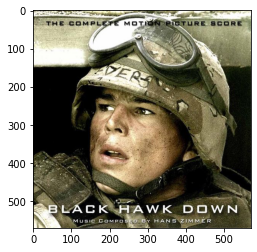

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(lion_data[95][0])
plt.show()
#BlackHawkDown:)

Setting Image Dimensions

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

**Feature and Label Creation**
- Feature is image
- Label is mask 

In [ ]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(lion_data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(lion_data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(lion_data.shape[0]):
    img = lion_data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in lion_data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1


Shape of X_train and Mask Array

In [ ]:
X_train.shape

(409, 224, 224, 3)

In [ ]:
masks.shape

(409, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.01176476 -0.01176471 -0.26274508]
  [-0.18431371 -0.20784312 -0.47450978]
  [ 0.23137259  0.20784318 -0.05882353]
  ...
  [ 0.95294118  0.94509804  0.73333335]
  [ 0.98431373  0.96078432  0.81960785]
  [ 0.98431373  0.95294118  0.86666667]]

 [[ 0.59215689  0.56078434  0.38823533]
  [ 0.36470592  0.33333337  0.14509809]
  [ 0.45098042  0.42745101  0.22352946]
  ...
  [ 0.82745099  0.82745099  0.58431375]
  [ 0.8509804   0.84313726  0.66274512]
  [ 0.70980394  0.69411767  0.56078434]]

 [[ 1.          0.99215686  0.90588236]
  [ 0.8509804   0.81960785  0.72549021]
  [ 0.80392158  0.78039217  0.65490198]
  ...
  [ 0.75686276  0.74901962  0.57647061]
  [ 0.92941177  0.92156863  0.78823531]
  [ 0.92156863  0.89803922  0.80392158]]

 ...

 [[ 0.92941177  0.95294118  0.69411767]
  [ 0.96862745  0.96078432  0.83529413]
  [ 1.          0.98431373  0.92156863]
  ...
  [-0.34117645 -0.38039213 -0.63137257]
  [-0.30196077 -0.34901959 -0.60000002]
  [-0.23137254 -0.28627449 -0.53725493]]

 [

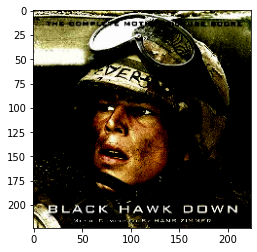

In [ ]:
from matplotlib import  pyplot

n = 95
print(X_train[n])
pyplot.imshow(X_train[n])

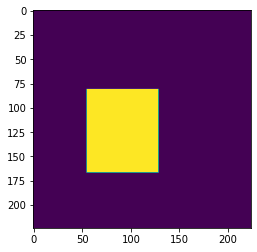

In [ ]:
pyplot.imshow(masks[n])

**Creating the Model** 
- **Adding MobileNet** as model with below parameter values
input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
include_top: False
alpha: 1.0
weights: "imagenet"
- **Adding UNET** architecture layers
This is the trickiest part of the project, you need to research and implement it correctly

In [ ]:
EPOCHS = 50
BATCH_SIZE = 1
PATIENCE = 10
ALPHA = 1.0

HEIGHT_CELLS = 224
WIDTH_CELLS = 224

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

THREADS = 1

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")
    for layer in model.layers:
        layer.trainable = trainable
    # model.summary()
    block_2 = model.get_layer("conv_pw_1_relu").output
    block_1 = model.get_layer("conv_pw_1_relu").output
    block0 = model.get_layer("conv_pw_3_relu").output
    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block_1])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)
    return Model(inputs=model.input, outputs=x)

**Calling the create_model function**

In [ ]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
co

# **Dice Coefficient function**

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon()) 

Loss Definition

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

# **Model Compilation**

In [ ]:
train_datagen = X_train
validation_datagen = masks

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)

model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient,'accuracy'])

**Checkpoint and Earlystopping**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

**Fitting the Model**

In [ ]:
model.fit(X_train, masks, epochs= 50, batch_size= 1, verbose=True, workers=THREADS,callbacks=[checkpoint, reduce_lr, stop],use_multiprocessing=True,validation_split=0.1)

Epoch 1/50
368/368 [==============================] - 56s 56ms/step - loss: 1.8728 - dice_coefficient: 0.3731 - accuracy: 0.0028 - val_loss: 1.3011 - val_dice_coefficient: 0.4354 - val_accuracy: 8.7108e-04

Epoch 00001: loss improved from inf to 1.44906, saving model to model-1.45.h5
Epoch 2/50
368/368 [==============================] - 20s 54ms/step - loss: 0.8059 - dice_coefficient: 0.6065 - accuracy: 0.0017 - val_loss: 1.3219 - val_dice_coefficient: 0.4156 - val_accuracy: 0.0015

Epoch 00002: loss improved from 1.44906 to 0.82124, saving model to model-0.82.h5
Epoch 3/50
368/368 [==============================] - 20s 55ms/step - loss: 0.6608 - dice_coefficient: 0.6678 - accuracy: 0.0018 - val_loss: 1.1303 - val_dice_coefficient: 0.4703 - val_accuracy: 0.0013

Epoch 00003: loss improved from 0.82124 to 0.63430, saving model to model-0.63.h5
Epoch 4/50
368/368 [==============================] - 20s 55ms/step - loss: 0.5614 - dice_coefficient: 0.7016 - accuracy: 0.0013 - val_loss: 1.10

# **Prediction**

Getting the predicted mask for sample image

In [ ]:
print(model.input_shape,)
print(model.output_shape)
print(X_train.shape)

(None, 224, 224, 3)
(None, 224, 224)
(409, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


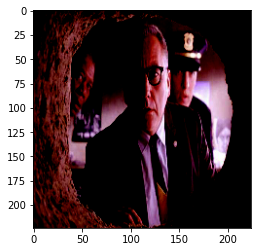

In [ ]:
n = 99
sample_image = X_train[n]
print(sample_image.shape)
pyplot.imshow(sample_image)


(1, 224, 224, 3)
(1, 224, 224)


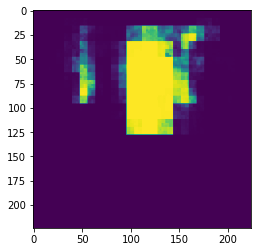

In [ ]:
sample_image = np.resize(sample_image, (1, 224, 224, 3))
print(sample_image.shape)
pred_face = model.predict(sample_image,)
print(pred_face.shape)
pred_face = np.resize(pred_face, (224, 224))
pyplot.imshow(pred_face)

Mask Imposition on the Sample Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


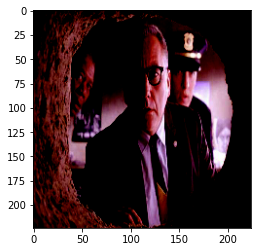

In [ ]:
imp_pred_face = np.resize(pred_face, (224,224))
res_image = np.resize(sample_image,  (224,224,3))
pyplot.imshow(res_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


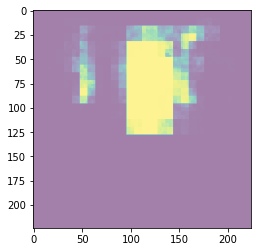

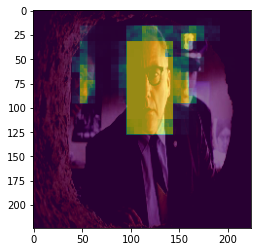

In [ ]:
#### Add your code here ####
pyplot.imshow(imp_pred_face, alpha=0.5)

fig = plt.figure(frameon=False)
im1 = plt.imshow(res_image)
im2 = plt.imshow(imp_pred_face,alpha=.6)
plt.show()